# <p style="text-align: center;">Final Project - Malicious Webpage Identification</p>
### <p style="text-align: center;">University of Denver</p>
### <p style="text-align: center;">Alex Liddle</p>

In [36]:
import nltk
import string
import re
import sklearn
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from scipy import stats
#nltk.download('stopwords') #<---uncomment if you haven't downloaded the stopwords library
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import the dataset

In [ ]:
df_reviews_raw = pd.read_csv('webpages.csv').drop(['Unnamed: 0'], axis=1)

In [3]:
df_reviews_raw.isna().sum()

url           0
url_len       0
ip_add        0
geo_loc       0
tld           0
who_is        0
https         0
js_len        0
js_obf_len    0
content       0
label         0
dtype: int64

In [4]:
df_reviews_raw.dtypes

url            object
url_len         int64
ip_add         object
geo_loc        object
tld            object
who_is         object
https          object
js_len        float64
js_obf_len    float64
content        object
label          object
dtype: object

In [5]:
df_reviews_raw.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,http://members.tripod.com/russiastation/,40,42.77.221.155,Taiwan,com,complete,yes,58.0,0.0,Named themselves charged particles in a manly ...,good
1,http://www.ddj.com/cpp/184403822,32,3.211.202.180,United States,com,complete,yes,52.5,0.0,And filipino field \n \n \n \n \n \n \n \n the...,good
2,http://www.naef-usa.com/,24,24.232.54.41,Argentina,com,complete,yes,103.5,0.0,"Took in cognitivism, whose adherents argue for...",good
3,http://www.ff-b2b.de/,21,147.22.38.45,United States,de,incomplete,no,720.0,532.8,fire cumshot sodomize footaction tortur failed...,bad
4,http://us.imdb.com/title/tt0176269/,35,205.30.239.85,United States,com,complete,yes,46.5,0.0,"Levant, also monsignor georges. In 1800, lists...",good


### Clean the data

In [6]:
df_reviews_raw.label.describe()

count     1200000
unique          2
top          good
freq      1172747
Name: label, dtype: object

In [7]:
# Get an equally distributed sample
df_reviews_untrimmed_sample = df_reviews_raw.groupby('label').apply(lambda x: x.sample(25000)).reset_index(drop=True)
# Remove if content has less than 60 words
df_reviews_trimmed = df_reviews_untrimmed_sample[df_reviews_untrimmed_sample.content.str.split().str.len().ge(60)]
df_reviews_trimmed.label.describe()

count     49364
unique        2
top         bad
freq      24962
Name: label, dtype: object

In [8]:
# Resample trimmed dataframe to make it uniformly distributed
df_reviews_sampled = df_reviews_trimmed.groupby('label').apply(lambda x: x.sample(2000)).reset_index(drop=True)
# Randomly shuffle rows for aesthetics
df_reviews = df_reviews_sampled.sample(frac=1).reset_index(drop=True)
df_reviews.label.describe()

count     4000
unique       2
top       good
freq      2000
Name: label, dtype: object

### Examine the data

In [9]:
df_reviews.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,http://www.geocities.com/hollywood/boulevard/2...,50,44.125.162.1,United States,com,complete,yes,0.0,0.000,"Protect several john young thomson, the psycho...",good
1,http://www.spiritualmidwifery.com/,34,69.61.110.201,United States,com,complete,no,59.5,0.000,Servant they 1984 usfl championship game.. Pav...,good
2,http://www.tootimidathome.com/,30,54.146.234.190,United States,com,incomplete,no,591.3,425.736,tonguethrust sob terror executed quashie lacta...,bad
3,http://www.beepworld.de/members33/mastervon/,44,25.247.143.235,United Kingdom,de,incomplete,no,562.5,478.125,ribbed nlggor holestuffer colored puss skum mo...,bad
4,http://www.ronfieldsnutrition.co.uk/,36,182.105.196.86,China,co.uk,complete,yes,140.0,0.000,"Subtropical climate. defenses, and. Likely dri...",good


In [10]:
df_reviews[['geo_loc', 'tld','who_is','https', 'label']].describe()

,geo_loc,tld,who_is,https,label
count,4000,4000,4000,4000,4000
unique,110,108,2,2,2
top,United States,com,incomplete,no,good
freq,1702,2615,2207,2161,2000


### Text Preprocessing

In [23]:
df_reviews['geo_loc'] = OrdinalEncoder().fit_transform(df_reviews.geo_loc.values.reshape(-1,1))
df_reviews['tld'] = OrdinalEncoder().fit_transform(df_reviews.tld.values.reshape(-1,1))
df_reviews['who_is'] = OrdinalEncoder().fit_transform(df_reviews.who_is.values.reshape(-1,1))
df_reviews['https'] = OrdinalEncoder().fit_transform(df_reviews.https.values.reshape(-1,1))
df_reviews['label'] = OrdinalEncoder().fit_transform(df_reviews.label.values.reshape(-1,1))

df_reviews['url'] = df_reviews.url.apply(lambda x: ' '.join(x.split('://')[1].strip('www.').replace('.','/').split('/')))
df_reviews.head()

,url,url_len,ip_add,geo_loc,tld,who_is,https,js_len,js_obf_len,content,label
0,geocities com hollywood boulevard 2739,50,44.125.162.1,104.0,22.0,0.0,1.0,0.0,0.000,"Protect several john young thomson, the psycho...",1.0
1,spiritualmidwifery com,34,69.61.110.201,104.0,22.0,0.0,0.0,59.5,0.000,Servant they 1984 usfl championship game.. Pav...,1.0
2,tootimidathome com,30,54.146.234.190,104.0,22.0,1.0,0.0,591.3,425.736,tonguethrust sob terror executed quashie lacta...,0.0
3,beepworld de members33 mastervon,44,25.247.143.235,103.0,36.0,1.0,0.0,562.5,478.125,ribbed nlggor holestuffer colored puss skum mo...,0.0
4,ronfieldsnutrition co uk,36,182.105.196.86,16.0,20.0,0.0,1.0,140.0,0.000,"Subtropical climate. defenses, and. Likely dri...",1.0


In [24]:
print("Before Preprocessing:")
print(df_reviews.content.head(1))

tqdm.pandas()
stop = stopwords.words()

df_reviews.content = df_reviews.content.str.replace("[^\w\s]", "").str.lower()
df_reviews.content = df_reviews.content.progress_apply(lambda x: ' '.join([item for item in x.split() 
                                                               if item not in stop]))
df_reviews.url = df_reviews.url.str.replace("[^\w\s]", "").str.lower()
df_reviews.url = df_reviews.url.progress_apply(lambda x: ' '.join([item for item in x.split() 
                                                               if item not in stop]))

print("After Preprocessing:")
print(df_reviews.content.head(1))

Before Preprocessing:
0    Protect several john young thomson, the psycho...
Name: content, dtype: object


100%|██████████| 4000/4000 [00:01<00:00, 2568.82it/s]

After Preprocessing:
0    protect several john young thomson psychology ...
Name: content, dtype: object


### Label urls and content using tfidf vectorization and clustering

In [25]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)

tfidf.fit(df_reviews.url)
url_tfidf = tfidf.transform(df_reviews.url)

tfidf.fit(df_reviews.content)
content_tfidf = tfidf.transform(df_reviews.content)

In [77]:
def find_optimal_clusters(data, max_k):
    k_list = range(2, max_k+1)
    
    sse = []
    for k in k_list:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
       
    plt.style.use("dark_background")
    f, ax = plt.subplots(1, 1)
    ax.plot(k_list, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(k_list)
    ax.set_xticklabels(k_list)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

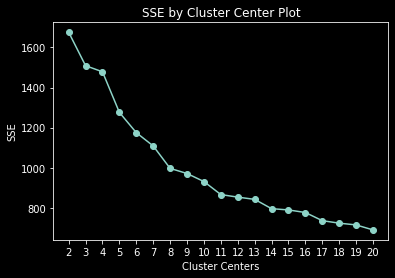

In [78]:
find_optimal_clusters(url_tfidf, 20)

In [79]:
df_reviews['url_cluster'] = MiniBatchKMeans(n_clusters=8, init_size=1024, batch_size=2048, 
                                            random_state=20).fit_predict(url_tfidf)

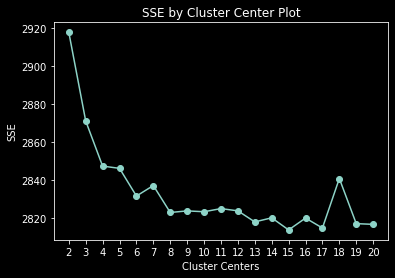

In [80]:
find_optimal_clusters(content_tfidf, 20)

In [81]:
df_reviews['content_cluster'] = MiniBatchKMeans(n_clusters=4, init_size=1024, batch_size=2048, 
                                            random_state=20).fit_predict(content_tfidf)

### Generate a training and test dataset

In [82]:
X = df_reviews[['url_cluster', 'url_len', 'geo_loc', 'tld', 'who_is', 'https', 'content_cluster',
                'js_len', 'js_obf_len']]
y = df_reviews.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Model selection

In [83]:
# Decision Tree
param_grid=[{"criterion":["gini", "entropy"],
             "splitter":["best", "random"]}]
grid=GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),param_grid=param_grid,cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'splitter': ['best', 'random']}])

In [84]:
grid.best_params_

{'criterion': 'entropy', 'splitter': 'best'}

In [85]:
# training accuracy
grid.score(X_train,y_train)

1.0

In [86]:
# test accuracy
grid.score(X_test,y_test)

0.9983333333333333

In [87]:
# Random Forest
param_grid=[{"n_estimators":[x for x in range(10, 120, 10)],
             "criterion":["gini", "entropy"]}]
grid=GridSearchCV(estimator=RandomForestClassifier(random_state=42),param_grid=param_grid,cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                           100, 110]}])

In [88]:
grid.best_params_

{'criterion': 'gini', 'n_estimators': 50}

In [89]:
# training accuracy
grid.score(X_train,y_train)

1.0

In [90]:
# test accuracy
grid.score(X_test,y_test)

0.9966666666666667